# Ground Truth generation

# table of content
1) [Generation](#generation)
2) [Addition](#addition)
3) [Erase clusters](#erase-clusters)
4) [Clean IDs of clusters](#clean-ids-of-clusters)
5) [Change name of semantic and segmentation columns](#change-name-of-semantic-and-segmentation-columns)
6) [Show evolutionm of predicted instances vs GT](#show-evolution-of-predicted-instances-vs-gt)

### Dependencies and general utils

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import laspy
import pdal
import json
from tqdm import tqdm

### Generation

#### Utils

In [ ]:
def convert_las_to_laz(in_las, out_laz, verbose=True):
    """
    Convert a LAS file to a LAZ file, stripping all extra dimensions.

    Parameters:
    - in_las: str, path to the input .las file
    - out_laz: str, path to the output .laz file
    - verbose: bool, whether to print a success message

    Returns:
    - None
    """
    pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": in_las
            },
            {
                "type": "writers.las",
                "filename": out_laz,
                "compression": "laszip",  # Ensure compression to LAZ
            }
        ]
    }

    # Create and execute the pipeline
    pipeline = pdal.Pipeline(json.dumps(pipeline_json))
    pipeline.execute()

    if verbose:
        print(f"LAZ file saved at {out_laz}")

def convert_pcd_to_laz(in_pcd, out_laz, verbose=True):
    pipeline_json = {
        "pipeline": [
            in_pcd,  # Read the PCD file
            {
                "type": "writers.las",
                "filename": out_laz,
                "compression": "laszip"  # Ensures .laz compression
                ""
            },
            {
                "type": "filters.reprojection",
                "in_srs": "EPSG:4326",
                "out_srs": "EPSG:2056"
            }
        ]
    }

    # Run the PDAL pipeline
    pipeline = pdal.Pipeline(json.dumps(pipeline_json))
    pipeline.execute()
    
    if verbose:
        print(f"LAZ file saved in {out_laz}")

def convert_laz_to_pcd(in_laz, out_pcd, verbose=True):
    laz = laspy.read(in_laz)

    # Gathering all attributes from laz file
    points = np.vstack((laz.x, laz.y, laz.z)).T

    attributes = {}
    for attribute in laz.point_format.dimensions:
        if attribute.name in ['X', 'Y', 'Z']:
            continue
        attributes[attribute.name] = getattr(laz, attribute.name)
    
    # Preparing data for pcd
    num_points = points.shape[0]
    fields = ["x", "y", "z"] + list(attributes.keys())  # All field names
    types = ["F", "F", "F"] + ["F" for _ in attributes]  # Float32 fields
    sizes = [4] * len(fields)  # 4-byte float per field

    # Stack all data into a single NumPy array
    data = np.column_stack([points] + [attributes[key] for key in attributes])

    # Write to a PCD file
    with open(out_pcd, "w") as f:
        f.write(f"VERSION 0.7\n")
        f.write(f"FIELDS {' '.join(fields)}\n")
        f.write(f"SIZE {' '.join(map(str, sizes))}\n")
        f.write(f"TYPE {' '.join(types)}\n")
        f.write(f"COUNT {' '.join(['1'] * len(fields))}\n")
        f.write(f"WIDTH {num_points}\n")
        f.write(f"HEIGHT 1\n")
        f.write(f"VIEWPOINT 0 0 0 1 0 0 0\n")
        f.write(f"POINTS {num_points}\n")
        f.write(f"DATA ascii\n")
    
        # Write data
        np.savetxt(f, data, fmt=" ".join(["%.6f"] * len(fields)))

    if verbose:
        print(f"PCD file saved in {out_pcd}")


#### Generate

In [8]:
# Loading sources
src_folder_instances = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\cluster_4\gt"
src_original_prediction = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\cluster_4\color_grp_full_tile_331.laz"
src_folder_result = r"..\data\full_dataset\selection\clusters_4\gt"

In [9]:
# Generate from laz to pcd for manual cleaning of the samples
files = [x for x in os.listdir(src_folder_instances) if x.endswith('.laz')]
src_pcd_loc = os.path.join(src_folder_instances, 'pcd')
os.makedirs(src_pcd_loc, exist_ok=True)
for _, file in tqdm(enumerate(files), total=len(files)):
    file_out = file.split('.laz')[0] + '.pcd'
    convert_laz_to_pcd(os.path.join(src_folder_instances, file), os.path.join(src_pcd_loc, file_out), verbose=False)

100%|██████████| 5/5 [00:00<00:00, 68.04it/s]


In [10]:
# Once cleaned, generate from pcd to laz in new folder
src_folder_instances = os.path.join(src_folder_instances, 'pcd/modified_samples')
files = [x for x in os.listdir(src_folder_instances) if x.endswith('.pcd')]
for _, file in tqdm(enumerate(files), total=len(files)):
    src_in = os.path.join(src_folder_instances, file)
    src_out = os.path.join(src_folder_instances, file.split('.pcd')[0] + '.laz')
    convert_pcd_to_laz(src_in, src_out,verbose=False)

100%|██████████| 5/5 [00:00<00:00, 32.82it/s]


In [ ]:
# Load original and reset/create gt columns
full_tile = laspy.read(src_original_prediction)
full_tile.add_extra_dim(laspy.ExtraBytesParams('gt_semantic',type="uint16"))
full_tile.add_extra_dim(laspy.ExtraBytesParams('gt_instance',type="uint16"))

In [ ]:
# Loop on gt instances and set the correct values in the full tile
list_instances_src = [x for x in os.listdir(src_folder_instances) if x.endswith('.laz')]
rounding = 2
semantic_layer = np.zeros(len(full_tile))
instance_layer = np.zeros(len(full_tile))
for id_instance, instance_src in tqdm(enumerate(list_instances_src), total=len(list_instances_src)):
    instance = laspy.read(os.path.join(src_folder_instances, instance_src))
    coords = list(zip(np.round(instance.x, rounding), np.round(instance.y, rounding), np.round(instance.z, rounding)))
    mask = np.array([(x,y,z) in coords for x, y, z in zip(np.round(full_tile.x, rounding), np.round(full_tile.y, rounding), np.round(full_tile.z, rounding))])
    semantic_layer[mask] = 1
    instance_layer[mask] = id_instance + 1

setattr(full_tile, 'gt_semantic', semantic_layer)
setattr(full_tile, 'gt_instance', instance_layer)

# save file
new_file = os.path.join(os.path.join(src_folder_result), os.path.basename(src_original_prediction).split('.laz')[0] + '_gt.laz')
full_tile.write(new_file)

100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


### Addition

In [ ]:
# Loading sources
src_folder_instances = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\cluster_2\gt\round2"
src_target = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\gt\color_grp_full_tile_331_gt.laz"
tile_target = laspy.read(src_target)

assert "gt_semantic" in tile_target.point_format.dimension_names
assert "gt_instance" in tile_target.point_format.dimension_names

In [46]:
# Generate from laz to pcd for manual cleaning of the samples
files = [x for x in os.listdir(src_folder_instances) if x.endswith('.laz')]
src_pcd_loc = os.path.join(src_folder_instances, 'pcd')
os.makedirs(src_pcd_loc, exist_ok=True)
for _, file in tqdm(enumerate(files), total=len(files)):
    file_out = file.split('.laz')[0] + '.pcd'
    convert_laz_to_pcd(os.path.join(src_folder_instances, file), os.path.join(src_pcd_loc, file_out), verbose=False)

100%|██████████| 10/10 [00:00<00:00, 40.47it/s]


In [55]:
# Once cleaned, generate from pcd to laz in new folder
src_folder_instances = os.path.join(src_folder_instances, 'pcd/modified_samples')
files = [x for x in os.listdir(src_folder_instances) if x.endswith('.pcd')]
for _, file in tqdm(enumerate(files), total=len(files)):
    src_in = os.path.join(src_folder_instances, file)
    src_out = os.path.join(src_folder_instances, file.split('.pcd')[0] + '.laz')
    convert_pcd_to_laz(src_in, src_out,verbose=False)

100%|██████████| 9/9 [00:00<00:00, 30.12it/s]


In [ ]:
# Loop on gt instances and set the correct values in the full tile
list_instances_src = [x for x in os.listdir(src_folder_instances) if x.endswith('.laz')]
rounding = 2
semantic_layer = np.array(tile_target.gt_semantic)
instance_layer = np.array(tile_target.gt_instance)
instance_val = np.max(tile_target.gt_instance) + 1
for id_instance, instance_src in tqdm(enumerate(list_instances_src), total=len(list_instances_src)):
    instance = laspy.read(os.path.join(src_folder_instances, instance_src))
    coords = list(zip(np.round(instance.x, rounding), np.round(instance.y, rounding), np.round(instance.z, rounding)))
    mask = np.array([(x,y,z) in coords for x, y, z in zip(np.round(tile_target.x, rounding), np.round(tile_target.y, rounding), np.round(tile_target.z, rounding))])
    semantic_layer[mask] = 1
    instance_layer[mask] = instance_val
    instance_val += 1

setattr(tile_target, 'gt_semantic', semantic_layer)
setattr(tile_target, 'gt_instance', instance_layer)


100%|██████████| 9/9 [01:39<00:00, 11.05s/it]


In [ ]:
# save file
new_file = os.path.join(os.path.join(src_folder_result), os.path.basename(src_target).split('.laz')[0] + '_2.laz')
tile_target.write(new_file)

### Erase clusters

In [ ]:
tree_ids_to_erase = [100]
src_tile = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\gt\color_grp_full_tile_317_gt.laz"
tile = laspy.read(src_tile)
assert "gt_instance_segmentation" in list(tile.point_format.dimension_names)

for tree_id in tree_ids_to_erase:
    mask = tile.gt_instance_segmentation == tree_id
    tile.gt_instance_segmentation[mask] = 0.0
    print(f"Tree with id {tree_id} of size {np.sum(mask)} deleted")
tile.write(src_tile)

Tree with id 100 of size 0 deleted


### Clean ids of clusters

In [43]:
src_tile = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters_4\gt\color_grp_full_tile_317_gt.laz"
tile = laspy.read(src_tile)
assert "gt_instance_segmentation" in list(tile.point_format.dimension_names)
max_id = np.max(tile.gt_instance_segmentation)
down_jump = 0
for _, id in tqdm(enumerate(range(max_id+1)), total=max_id+1):
    mask = tile.gt_instance_segmentation == id
    if np.sum(mask) == 0:
        print(f"Empty id: {id}")
        down_jump += 1
        continue

    if down_jump > 0:
        print(id, " -> ", id - down_jump)
        tile.gt_instance_segmentation[mask] = id - down_jump
tile.write(src_tile)


100%|██████████| 144/144 [00:00<00:00, 615.63it/s]


### Other stuff

#### Change name of semantic and segmentation columns

In [ ]:
src_tile = r"D:\PDM_repo\Github\PDM\data\gt\color_grp_full_tile_331_gt.laz"
las = laspy.read(src_tile)
for old_val, new_val in zip(['gt_semantic_segmentation', 'gt_instance_segmentation'],['gt_semantic', 'gt_instance']):
    print("Old val: ", old_val)
    print("New val: ", new_val)
    
    # Get the values
    values = las[old_val]

    # Remove the old dimension from extra dimensions (only works for ExtraBytes dimensions)
    if old_val in (las.point_format.dimension_names):
        las.remove_extra_dim(old_val)

    # Add new dimension
    las.add_extra_dim(laspy.ExtraBytesParams(name=new_val, type=np.float32))  # Change type if needed
    las[new_val] = values

# Save to new file
las.write(src_tile)

Old val:  gt_semantic_segmentation
New val:  gt_semantic
Old val:  gt_instance_segmentation
New val:  gt_instance


### Add color field for instances

In [ ]:
src_tile = r"D:\PDM_repo\Github\PDM\results\for_paper\final\20250701_162429_final_on_gt\pseudo_labels\color_grp_full_tile_317_gt.laz"

# Load file
las = laspy.read(src_tile)
instance_ids = np.array(getattr(las, "treeID"))
set_instances = [int(x) for x in set(instance_ids)]  # Or your instance field
print(set_instances)

# Define your custom color palette
color_map = [
    (255, 0, 0),       # Bright Red
    (255, 165, 0),     # Orange
    (255, 255, 0),     # Yellow
    (128, 128, 0),     # Olive
    (0, 128, 0),       # Green
    (0, 255, 0),       # Bright Green
    (154, 205, 50),    # Yellow Green
    (85, 107, 47),     # Dark Olive Green
    (139, 69, 19),     # Saddle Brown
    (210, 105, 30),    # Chocolate
    (255, 105, 180),   # Hot Pink
    (255, 20, 147),    # Deep Pink
    (255, 192, 203),   # Light Pink
    (255, 0, 255),     # Magenta
    (128, 0, 128),     # Purple
    (148, 0, 211),     # Dark Violet
    (160, 82, 45),     # Sienna
    (222, 184, 135),   # Burlywood
    (255, 215, 0),     # Gold
    (218, 112, 214)    # Orchid (mild purple-pink)
]
print(set_instances)
instance_color_map = {x: color_map[x%len(color_map)] for x in set_instances}

# Assign RGB colors
r = np.zeros_like(instance_ids, dtype=np.uint16)
g = np.zeros_like(instance_ids, dtype=np.uint16)
b = np.zeros_like(instance_ids, dtype=np.uint16)

for inst_id, (r_val, g_val, b_val) in instance_color_map.items():
    mask = instance_ids == inst_id
    if inst_id == 0:
        r[mask] = 0
        g[mask] = 0
        b[mask] = 65535
    else:
        r[mask] = r_val * 256  # LAS stores 16-bit, 8-bit is scaled ×256
        g[mask] = g_val * 256
        b[mask] = b_val * 256

# Attach colors to LAS
las.red = r
las.green = g
las.blue = b

# Save new file
las.write(src_tile.split('.laz')[0] + "_colored_instances_pseudo_labels.laz")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4

### Show evolution of predicted instances vs gt

In [ ]:
src_eval = r"D:\PDM_repo\Github\PDM\results\eval\20250701_162429_final_on_gt"
src_gt = "../data/gt/gt"
tiles = [x for x in os.listdir(src_gt) if x.endswith('.laz')]
evolution = {x:[] for x in tiles}
gt_val = {x:[] for x in tiles}

# finding the number of loops
lst_loops = []
num_loop = 0
while True:
    if not str(num_loop) in os.listdir(src_eval):
        break
    lst_loops.append(num_loop)
    num_loop += 1
if num_loop == 0:
    print("No loop folder from which to extract the pseudo-labels")

# computing predictions and gt
for _, loop in tqdm(enumerate(range(num_loop)), total=num_loop, desc="Computing"):
    pseudo_labels = os.path.join(src_eval, str(loop), 'pseudo_labels')
    for tile_src in os.listdir(pseudo_labels):
        tile = laspy.read(os.path.join(pseudo_labels, tile_src))
        evolution[tile_src].append(len(set(tile.treeID)))
        gt_val[tile_src].append(len(set(tile.gt_instance)))
print(evolution)
print(gt_val)

Computing: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

{'color_grp_full_tile_316_gt.laz': [136, 151, 154, 158, 158, 160, 160, 161, 161, 162], 'color_grp_full_tile_317_gt.laz': [162, 170, 178, 181, 182, 184, 187, 189, 189, 189], 'color_grp_full_tile_331_gt.laz': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'color_grp_full_tile_77_gt.laz': [10, 14, 14, 14, 14, 14, 15, 15, 15, 15]}
{'color_grp_full_tile_316_gt.laz': [153, 153, 153, 153, 153, 153, 153, 153, 153, 153], 'color_grp_full_tile_317_gt.laz': [153, 153, 153, 153, 153, 153, 153, 153, 153, 153], 'color_grp_full_tile_331_gt.laz': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 'color_grp_full_tile_77_gt.laz': [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]}


dict_keys(['color_grp_full_tile_316_gt.laz', 'color_grp_full_tile_317_gt.laz', 'color_grp_full_tile_331_gt.laz', 'color_grp_full_tile_77_gt.laz'])


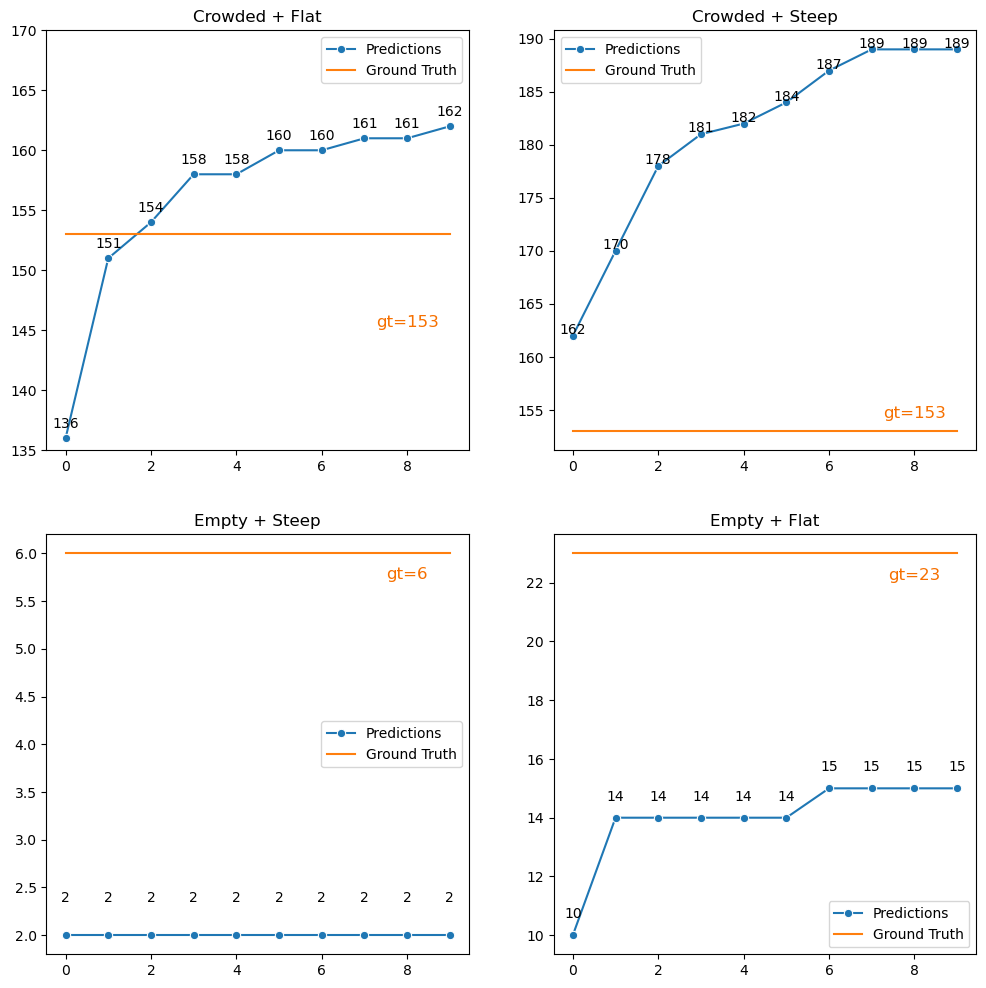

In [ ]:
src_destination = r"C:\Users\swann\Documents\EPFL\Master\PDM_admin\medias\results\gt\gt_Predsvsgt.png"
# show results
group_names = ['Crowded + Flat', 'Crowded + Steep', 'Empty + Steep', 'Empty + Flat']
fig, axs = plt.subplots(2,2, figsize=(12, 12))
axs = axs.flatten()
for idx, (tile, data) in enumerate(evolution.items()):
    x = np.array(range(len(data)))
    y = np.array(data)
    span = max(gt_val[tile][0], np.max(x)) - (np.min(y)-5)
    sns.lineplot(x=x, y=y, errorbar=None, marker='o', label="Predictions", ax=axs[idx])
    sns.lineplot(x=x, y=np.array(gt_val[tile]), errorbar=None, label=f"Ground Truth", ax=axs[idx])

    # Annotate each point
    for i in range(len(x)):
        axs[idx].text(x[i], y[i] + 0.8 * span / 30,  # slightly above the error bar
                f"{round(y[i],2)}",              # formatted value
                ha='center', va='bottom', fontsize=10, color='black')
    axs[idx].set_title(group_names[idx])
axs[0].set_ylim([135, 170])
axs[0].text(8, 145, 'gt=153', ha='center', va='bottom', fontsize=12, color='#f67000')
axs[1].text(8, 154, 'gt=153', ha='center', va='bottom', fontsize=12, color='#f67000')
axs[2].text(8, 5.7, 'gt=6', ha='center', va='bottom', fontsize=12, color='#f67000')
axs[3].text(8, 22, 'gt=23', ha='center', va='bottom', fontsize=12, color='#f67000')
plt.savefig(src_destination)
plt.show()
plt.close()